## Useful libraries

In [351]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch_geometric
import sklearn

In [352]:
## TODO: https://medium.com/math-simplified/checking-for-linear-dependence-in-sympy-9776b66dbe75

## Utility functions

In [353]:
## Idea: Adding categroized features might a problem -> So lets completely remove them for now since they dont have an inherent order
def categorize_columns(df, columns):
    for column in columns:
        #df[column] = df[column].astype("category")
        df.pop(column)
    # cat_columns = df.select_dtypes(['category']).columns
    # df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [354]:
def z_scale(df_z_scaled, columns): ## is a bit better for neural networks
    # for column in columns:
    #     df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()   
    return df_z_scaled

In [355]:
from pandas.api.types import is_numeric_dtype
def remove_uninformative_columns(df, columns):
    ## removes categorcial columns where we have no duplicates (i.e., columns with all different categorical values like ids)
    filtered_columns = []
    for column in columns:
        all_values_in_column_identical = df[column].unique().shape[0] < 2
        if all_values_in_column_identical:
            continue
        category_has_duplicates = df.duplicated(subset=column).sum()> 0 ##is informative
        if category_has_duplicates or is_numeric_dtype(df[column]) :
            filtered_columns.append(column)
    return filtered_columns

In [356]:
import torch
def reverse_edge_index(torch_tensor):
    reversed_torch_tensor = torch.zeros_like(torch_tensor)
    reversed_torch_tensor[:, 0] = torch_tensor[:, 1]
    reversed_torch_tensor[:, 1] = torch_tensor[:, 0]
    return reversed_torch_tensor

## What we need
- Gene node feature #genes x #features
- Model node feature #models x features (for now includes drug inofrmation and the drug IC50 target for simplicity) (more complicated than I expected)
  -> later edge attribute prediction?
- Gene_model_edge_index_cn #edges x 2
- Gene_model_edge_index_mutations #edges x 2
- Gene_model_edge_index_geneexpressions #edges x 2
- Gene_model_edge_attributes_cn #edges x #attributes
- Gene_model_edge_attributes_mutations #edges x #attributes
- Gene_model_edge_attributes_geneexpressions #edges x #attributes

  Het-GAT for regression task with MSE as loss

## Read human genome

## Get gene symbols to human genome index dataframe (is in nested list semicolon, comma separated)

In [358]:
def get_gene_idx_to_gene_symbol(human_genome):
    sem_split = human_genome[3].str.split("; ")
    comma_split = sem_split.map(lambda n: n[0]).str.split(",")
    exploded_gene_symbols = comma_split.explode().str.strip().to_frame()
    exploded_gene_symbols = exploded_gene_symbols.rename(columns={3:"symbol"})
    exploded_gene_symbols = exploded_gene_symbols.drop_duplicates(subset = "symbol")
    exploded_gene_symbols["human_genome_index"] = exploded_gene_symbols.index
    exploded_gene_symbols = exploded_gene_symbols.reset_index(drop=True)
    return exploded_gene_symbols

In [359]:
gene_idx_to_gene_symbol_df = get_gene_idx_to_gene_symbol(human_genome)
gene_idx_to_gene_symbol_df

,symbol,human_genome_index
0,MIR6859-1,0
1,hsa-mir-6859-1,0
2,MIR1302-2,1
3,MIRN1302-2,1
4,hsa-mir-1302-2,1
...,...,...
78333,G antigen 4,24683
78334,putative TAF11-like protein ENSP05220103537,24685
78335,Uncharacterized LOC132932482,24686
78336,POC1B-DUSP6,24687


In [360]:
perfect_gene_features = ['FIGN', 'FAR2P2', 'UBAC2-AS1', 'PKM', 'LINC01752', 'FOXCUT',
       'COL9A3', 'SPP1', 'CEP170P1', 'NF2', 'INPP1', 'ARL9', 'BTBD19',
       'LYPD1', 'MYH14', 'ELOVL7', 'ROMO1', 'HSPE1P21', 'RPS26P21',
       'FUT8', 'TMEM127', 'POU5F1P5', 'MANCR', 'GLO1', 'VCP', 'LPGAT1',
       'C4BPB', 'ADGRF4', 'CCDC57', 'KLK8', 'LINC02551', 'NGEF',
       'ANKDD1B', 'SNHG30', 'LINC01133', 'FAM189A2', 'HMMR', 'KRTAP3-1',
       'TIAM1', 'SHKBP1', 'FASTKD3', 'CARD14', 'SPATS2L', 'TMED7-TICAM2',
       'PABPC1P3', 'MTND6P4', 'EPS8L1', 'MIR99AHG', 'PCSK6-AS1', 'IRF6',
       'SNORD124', 'A2M-AS1', 'SMOC1', 'SLC22A3', 'IGFBP6', 'ANXA2R',
       'PPFIA3', 'CD9', 'GAS2L1', 'HEIH', 'GGACT', 'ANKRA2', 'NUP210',
       'FAM43B', 'MIR574', 'KRT23', 'CTU1', 'PELO', 'ERICH5', 'LRRC2',
       'ZNF17', 'LPP-AS2', 'HLA-F-AS1', 'RNU6-37P', 'MTMR11', 'TAGLN',
       'AKAP12', 'PROM2', 'LYPLAL1-DT', 'PCDHB17P', 'KCNH3', 'CCDC61',
       'RPS2P55', 'SCARNA8', 'LINC01694', 'SNHG25', 'INHA', 'CHMP6',
       'SLC44A4', 'PIGC', 'ERCC6', 'MAGEH1', 'OR7E91P', 'RAPGEF4',
       'RPS20', 'NECTIN3-AS1', 'LINC00622', 'RCN1P2', 'IPO4', 'VSIG10L',
       'IMPA1P1', 'KLK7', 'IGFBP5', 'GJC2', 'NFRKB', 'RPL35P6', 'ADAM33',
       'GDI2', 'BEND7', 'USPL1', 'FLRT3', 'RBM23', 'KLK14', 'AGAP14P',
       'LINC02331', 'M1AP', 'UCN2', 'OSBPL9', 'SEMA4F', 'ERMP1', 'OPLAH',
       'TMEM87A', 'ZNF674-AS1', 'INSIG2', 'MIR3192', 'NELFA', 'RPSAP58',
       'WBP4', 'TCIRG1', 'AMZ1', 'FGFBP1', 'CDC27P1', 'COLGALT2', 'TGM2',
       'PEDS1', 'MMP10', 'RPL7AP11', 'MFSD14A', 'TMEM253', 'DNAH5',
       'TMLHE', 'HERC5', 'CNPY2', 'SNAPC2', 'GJB7', 'OCRL', 'MGLL',
       'ANO1', 'CNOT3', 'SLC5A6', 'NAT1', 'ANKRD40', 'PLEKHG4B', 'FLG',
       'LINC02340', 'ABHD11', 'LINC00659', 'RN7SL552P', 'IHO1', 'AP1M2',
       'CCNB1IP1', 'AK4', 'SULT1C4', 'IGFL2-AS1', 'SVIL-AS1', 'PTPA',
       'PLXDC1', 'SLC30A3', 'SH3BP2', 'KCNK2', 'MTCO3P12', 'MIR6835',
       'MRPL37', 'MAGEF1', 'PRR34-AS1', 'HDLBP', 'SDR42E1', 'CASP7',
       'NKILA', 'AFF1', 'NUPR1', 'CUBN', 'TGFBR3', 'PPP1R10', 'MIR181B2',
       'LIF', 'IFRD1', 'TLL2', 'ERICH6-AS1', 'RNU6-589P', 'A1BG-AS1',
       'MSX2', 'MFSD3', 'LINC02102', 'LDHAL6FP', 'PTGR1', 'CDYL2', 'PEX3',
       'EEF1A1P11', 'LSMEM2', 'LINC01040', 'ZNF776', 'SLC44A2', 'CCDC9',
       'EXOSC2', 'ATG101', 'MYD88', 'SNORA79B', 'SLC3A2', 'CERNA1',
       'LYPD3', 'USP2', 'RPS20P2', 'VNN1', 'KREMEN2', 'HTR1D', 'TBC1D3C',
       'RPS6KA2', 'CHKB-CPT1B', 'RNU6-469P', 'CXADR', 'BAZ1A',
       'LINC00960', 'FTH1P23', 'RNASEK-C17orf49', 'VILL', 'BNIP3P5',
       'PARP3', 'COBL', 'TGFB3', 'CDO1', 'CT45A11P', 'LASP1', 'HYI-AS1',
       'NRBP2', 'CYB561A3', 'C1QTNF12', 'IQUB', 'MIR6499', 'TAFA3',
       'TRPV6', 'CCL20', 'SLC16A3', 'RASA1', 'POMT1', 'RBM17', 'CYP4X1',
       'SPDEF', 'VEGFC', 'APOBEC3A', 'MIR4754', 'METTL15P1', 'PNKP',
       'UBE2L3', 'ARSK', 'BACH1-AS1', 'TRPM4', 'KCTD14', 'NNT-AS1',
       'B3GALNT1', 'PRSS35', 'UGT1A3', 'MIR6826', 'PRSS41', 'MT-CO3',
       'SIRT2', 'AGAP12P', 'SNX18P9', 'YBX1P1', 'ADRA1B', 'ACTL11P',
       'MINDY3', 'CEP250', 'STAG3L5P', 'TGFA-IT1', 'IER5', 'UNC5CL',
       'HNRNPA3P12', 'FGB', 'SOD3', 'OBSL1', 'STX10', 'PDRG1', 'SPATA17',
       'PCED1B', 'EFNB2', 'CHCHD2P2', 'GYG1P1', 'CD109', 'EEF2K',
       'ADAMTSL4', 'PERM1', 'CDC20B', 'RGS5', 'WNT2', 'PCBP2', 'HOMEZ',
       'RPS12P27', 'ZNF615', 'BMS1P11', 'ZNF577', 'CFAP298', 'NRSN2',
       'TMEM139', 'SEPTIN7P3', 'RNU11-2P', 'RPL31P59', 'RASSF3', 'EFHD1',
       'ORAI3', 'RNU6-100P', 'ZNF662', 'VAMP8', 'HEPHL1', 'FSTL5',
       'FAM3D', 'HS3ST1', 'NUMB', 'MYLK4', 'CLDN16', 'LINC00460', 'PROM1',
       'PRRG2', 'CCDC6', 'GSC', 'CCDC157', 'GABARAPL1', 'RN7SKP160',
       'PGLYRP1', 'RPS5', 'BCAN', 'FAM107A', 'ADAMTS13', 'OR6A2',
       'ARPC1B', 'D2HGDH', 'JAZF1', 'KRTAP2-1', 'ARHGAP23', 'DEFB1',
       'ZNF584', 'LRP1B', 'POTEI', 'NLRP1', 'RNY1', 'C6orf15', 'B4GAT1',
       'SCARF1', 'LINC00643', 'CSGALNACT1', 'MIR1262', 'RNU6-377P',
       'RTN4RL1', 'JOSD2', 'ATXN7L3B', 'KCP', 'MAP2K1', 'C2orf88',
       'LAPTM4A', 'SSTR5-AS1', 'DAPK3', 'ZNF75D', 'PIGV', 'SAV1', 'PCGF2',
       'TOB2P1', 'DNAJB12', 'AK2P2', 'YWHABP2', 'CPT1B', 'PLK3', 'PODXL',
       'RPSAP18', 'PRPF6', 'VPS26BP1', 'CD47', 'PRR36', 'HERC2P3',
       'TMEM134', 'ATP8B1', 'WNT4', 'ERV3-1', 'PSMD10P2', 'SCRN3',
       'CDK10', 'CTSV', 'RNA5SP440', 'EIF1AD']

In [361]:
# perfect_gene_features = features
perfect_genes = gene_idx_to_gene_symbol_df[gene_idx_to_gene_symbol_df["symbol"].isin(perfect_gene_features)].reset_index(drop=True).groupby("human_genome_index")["symbol"].apply(list).reset_index(drop= True).explode()
perfect_gene_df = pd.DataFrame(columns = ["human_genome_index", "symbol"])
perfect_gene_df["symbol"] = perfect_genes
perfect_gene_df["human_genome_index"] = perfect_genes.index
gene_idx_to_gene_symbol_df = perfect_gene_df

## Generate nodes features for gene nodes

In [362]:
def get_gene_features(human_genome):
    categorize_columns(human_genome, human_genome.columns[:3])
    z_scale(human_genome, human_genome.columns[:3])
    print(human_genome)
    gene_features = human_genome["human_genome_index"].values #human_genome.loc[:, :2].values
    return gene_features

In [363]:
import numpy as np
gene_features = np.eye(gene_idx_to_gene_symbol_df.shape[0]) # get_gene_features(human_genome)

In [364]:
gene_features.shape

(295, 295)

## Generate node features for models (with target) and target labels

In [365]:
targets = pd.read_csv("target.csv",sep=";")
models = pd.read_csv("model_list_20240110.csv")
models.head()

,model_id,sample_id,patient_id,parent_id,model_name,synonyms,tissue,cancer_type,cancer_type_ncit_id,tissue_status,...,msh6_expression_by_ihc,braf_mutation_identified,braf_expression_by_ihc,pik3ca_mutation_identified,pten_expression_by_ihc,pten_mutation_identified,kras_mutation_identified,mismatch_repair_status,preoperative_ce_alevel,crispr_ko_data
0,SIDM01774,SIDS01659,SIDP01578,NaN,PK-59,NaN,Pancreas,Pancreatic Carcinoma,C3850,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,SIDM00192,SIDS00612,SIDP00541,NaN,SNU-1033,NaN,Large Intestine,Colorectal Carcinoma,C9383,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,SIDM01447,SIDS01466,SIDP01347,NaN,SNU-466,NaN,Central Nervous System,Glioblastoma,C3058,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,SIDM01554,SIDS01363,SIDP01247,NaN,IST-MES-2,NaN,Lung,Mesothelioma,C45662,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,SIDM01689,SIDS01631,SIDP01557,NaN,MUTZ-5,NaN,Haematopoietic and Lymphoid,B-Lymphoblastic Leukemia,C8644,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [422]:
models

,model_id,sample_id,patient_id,parent_id,model_name,synonyms,tissue,cancer_type,cancer_type_ncit_id,tissue_status,...,msh6_expression_by_ihc,braf_mutation_identified,braf_expression_by_ihc,pik3ca_mutation_identified,pten_expression_by_ihc,pten_mutation_identified,kras_mutation_identified,mismatch_repair_status,preoperative_ce_alevel,crispr_ko_data
0,SIDM01774,SIDS01659,SIDP01578,NaN,PK-59,NaN,Pancreas,Pancreatic Carcinoma,C3850,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,SIDM00192,SIDS00612,SIDP00541,NaN,SNU-1033,NaN,Large Intestine,Colorectal Carcinoma,C9383,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,SIDM01447,SIDS01466,SIDP01347,NaN,SNU-466,NaN,Central Nervous System,Glioblastoma,C3058,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,SIDM01554,SIDS01363,SIDP01247,NaN,IST-MES-2,NaN,Lung,Mesothelioma,C45662,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,SIDM01689,SIDS01631,SIDP01557,NaN,MUTZ-5,NaN,Haematopoietic and Lymphoid,B-Lymphoblastic Leukemia,C8644,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,SIDM02155,SIDS02010,SIDP01906,NaN,NZM3,NaN,Skin,Melanoma,C3224,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2151,SIDM02157,SIDS02040,SIDP01935,NaN,WM3772F,NaN,Eye,Melanoma,C7712,Metastasis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2152,SIDM02159,SIDS02033,SIDP01928,SIDM02121,HAP1,NaN,Haematopoietic and Lymphoid,Chronic Myelogenous Leukemia,C3174,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2153,SIDM01339,SIDS01788,SIDP01690,SIDM01851,SLR24,NaN,Kidney,Kidney Carcinoma,C4033,Tumour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [366]:
def get_transformed_merged_drug_model_df(models, targets):
    columns_with_most_val_filled = models.columns[models.isnull().sum(axis=0)/ models.shape[0] <= 0.1]
    filtered_columns = remove_uninformative_columns(models, columns_with_most_val_filled) ##all categorical
    filtered_columns.append("model_id") ## required for later join
    print(filtered_columns)
    models = models[filtered_columns].fillna("Unkown")
    columns_besides_id = list(filter(lambda x: x != "model_id", filtered_columns))
    models = categorize_columns(models, columns_besides_id)
    z_scale(models, columns_besides_id)
    models = models.rename(columns={"model_id":"SANGER_MODEL_ID"}) ##rename for join
    limited_drug_target = targets[targets["DRUG_ID"] == 1803] ##filter specific drug #1862
    limited_drug_target_filtered = limited_drug_target.loc[:, ["CELL_LINE_NAME", "SANGER_MODEL_ID", "MIN_CONC", "LN_IC50"]]
    limited_drug_target_filtered = categorize_columns(limited_drug_target_filtered, ["CELL_LINE_NAME"])
    z_scale(limited_drug_target_filtered, list(filter(lambda x: x not in ["LN_IC50", "SANGER_MODEL_ID"], limited_drug_target_filtered.columns)))
    model_drug_information = pd.merge(limited_drug_target_filtered, models, how="inner", on="SANGER_MODEL_ID") ## merge drug and model information

    model_drug_information["model_idx"] = model_drug_information.index ##store index for later joins to retrieve edge index
    return model_drug_information

In [367]:
merged_drug_model_df = get_transformed_merged_drug_model_df(models,  targets)

['sample_id', 'patient_id', 'model_name', 'tissue', 'cancer_type', 'cancer_type_ncit_id', 'tissue_status', 'sample_site', 'cancer_type_detail', 'model_type', 'growth_properties', 'gender', 'ethnicity', 'smoking_status', 'sample_treatment', 'crispr_ko_data', 'model_id']


In [368]:
def get_target_label_and_model_with_target_feature(model_drug_information):
    target_labels = model_drug_information.loc[:, "LN_IC50"].values # model_drug_information.pop("LN_IC50").values
    model_feature_columns = list(filter(lambda x: x not in ["model_idx", "SANGER_MODEL_ID"], model_drug_information.columns))
    print(model_feature_columns)
    model_and_target_features = model_drug_information[model_feature_columns].values
    return (target_labels, model_and_target_features)

In [369]:
target_labels, model_and_target_features = get_target_label_and_model_with_target_feature(merged_drug_model_df) ## If using this pop IC50 otherwise label leakage

['MIN_CONC', 'LN_IC50']


In [370]:
merged_drug_model_df.describe()

,MIN_CONC,LN_IC50,model_idx
count,7.170000e+02,717.000000,717.000000
mean,3.001600e-02,4.960259,358.000000
std,1.597060e-16,1.856540,207.124359
min,3.001600e-02,-0.737397,0.000000
25%,3.001600e-02,3.993791,179.000000
50%,3.001600e-02,5.316799,358.000000
75%,3.001600e-02,6.294390,537.000000
max,3.001600e-02,9.829512,716.000000


In [371]:
model_and_target_features = np.eye(model_and_target_features.shape[0])

In [372]:
target_labels.shape, model_and_target_features.shape

((717,), (717, 717))

## Generate edge indices and edge attributes

### Read copy numbers

In [373]:
copy_numbers = pd.read_csv("WES_pureCN_CNV_genes_20220623.csv")
copy_numbers.head()

,model_name,model_id,symbol,gene_id,chr_name,chr_start,chr_end,total_copy_number,minor_copy_number,loh,...,seg_mean,gene_mean,num_targets,focal,breakpoints,num_snps,gatk_mean_log2_copy_ratio,comment,source,data_type
0,MEC-1,SIDM00001,ABCB1,SIDG00064,chr7,87503966,87600461,3.0,1.0,False,...,0.599167,0.414125,28.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES
1,MEC-1,SIDM00001,ABL1,SIDG00150,chr9,130714099,130885948,3.0,1.0,False,...,0.599167,0.472693,12.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES
2,MEC-1,SIDM00001,BRD3,SIDG02504,chr9,134033313,134053689,3.0,1.0,False,...,0.599167,0.705704,11.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES
3,MEC-1,SIDM00001,CARD11,SIDG03455,chr7,2906361,2958783,3.0,1.0,False,...,0.599167,0.696245,23.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES
4,MEC-1,SIDM00001,CDK6,SIDG04156,chr7,92614869,92833599,3.0,1.0,False,...,0.599167,0.750720,7.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES


### Get edge index (model-[CopyNumbers]->gene)

In [374]:
def get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, df):
    human_genome_index_merged_df = pd.merge(gene_idx_to_gene_symbol_df, df, on="symbol", how = "inner")
    human_genome_index_merged_df = human_genome_index_merged_df.rename(columns={"model_id": "SANGER_MODEL_ID"}) ##rename for join
    model_gene_merged_df = pd.merge(human_genome_index_merged_df, merged_drug_model_df, on="SANGER_MODEL_ID", how="inner")
    return model_gene_merged_df

In [375]:
model_gene_merged_copy_number_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, copy_numbers)
model_to_gene_copy_number_edge_index = model_gene_merged_copy_number_df.loc[:, ["model_idx", "human_genome_index"]].values.astype(np.int64)
model_to_gene_copy_number_edge_index.shape

(9372, 2)

In [376]:
copy_numbers[copy_numbers["symbol"] == "TNFRSF14"].head(24)

,model_name,model_id,symbol,gene_id,chr_name,chr_start,chr_end,total_copy_number,minor_copy_number,loh,...,seg_mean,gene_mean,num_targets,focal,breakpoints,num_snps,gatk_mean_log2_copy_ratio,comment,source,data_type
679,MEC-1,SIDM00001,TNFRSF14,SIDG38237,chr1,2556388,2563527,2.0,1.0,False,...,0.018974,0.203659,7.0,False,0.0,3166.0,0.001309,POOR GOF (70.4%),Sanger,WES
848,MEC-1,SIDM00001,TNFRSF14,SIDG38237,chr1,2556388,2563527,2.0,1.0,False,...,0.149810,0.001817,7.0,False,0.0,164.0,-0.012460,POOR GOF (57.6%);NOISY LOG-RATIO;NOISY SEGMENT...,Broad,WES
2222,NBsusSR,SIDM00002,TNFRSF14,SIDG38237,chr1,2556388,2563527,3.0,1.0,False,...,-0.221313,-0.192888,7.0,False,0.0,758.0,-0.236619,POOR GOF (78.3%);POTENTIAL SAMPLE CONTAMINATION,Sanger,WES
2845,M14,SIDM00003,TNFRSF14,SIDG38237,chr1,2556388,2563527,4.0,2.0,False,...,0.340054,0.354836,7.0,False,0.0,2993.0,0.357526,POTENTIAL SAMPLE CONTAMINATION,Sanger,WES
3182,MCAS,SIDM00008,TNFRSF14,SIDG38237,chr1,2556388,2563527,4.0,2.0,False,...,0.179029,0.223966,7.0,False,0.0,211.0,0.020543,POOR GOF (73.2%);NOISY LOG-RATIO;NOISY SEGMENT...,Broad,WES
4126,Malme-3M,SIDM00011,TNFRSF14,SIDG38237,chr1,2556388,2563527,3.0,1.0,False,...,-0.169298,-0.077307,7.0,False,0.0,1427.0,-0.312813,POOR GOF (71.7%);NOISY LOG-RATIO;NOISY SEGMENT...,Broad,WES
4951,M120327_3,SIDM00013,TNFRSF14,SIDG38237,chr1,2556388,2563527,3.0,1.0,False,...,-0.020660,-0.109530,7.0,False,0.0,108.0,-0.122533,NaN,Sanger,WES
5729,KYSE-30,SIDM00015,TNFRSF14,SIDG38237,chr1,2556388,2563527,3.0,0.0,True,...,0.028441,-0.076286,7.0,False,0.0,318.0,-0.139138,POOR GOF (76.6%);NOISY LOG-RATIO;NOISY SEGMENT...,Broad,WES
6257,KP-N-S19s,SIDM00016,TNFRSF14,SIDG38237,chr1,2556388,2563527,1.0,0.0,True,...,-1.076784,-1.090163,7.0,False,0.0,390.0,-1.243077,POOR GOF (70.8%);NOISY LOG-RATIO;NOISY SEGMENT...,Broad,WES
7267,NCI-H2286,SIDM00017,TNFRSF14,SIDG38237,chr1,2556388,2563527,2.0,1.0,False,...,0.280241,0.579134,7.0,False,0.0,1073.0,0.117469,POOR GOF (61.6%);NOISY LOG-RATIO;NOISY SEGMENT...,Broad,WES


In [377]:
model_gene_merged_copy_number_df.head(30)

,human_genome_index,symbol,model_name,SANGER_MODEL_ID,gene_id,chr_name,chr_start,chr_end,total_copy_number,minor_copy_number,...,focal,breakpoints,num_snps,gatk_mean_log2_copy_ratio,comment,source,data_type,MIN_CONC,LN_IC50,model_idx
0,39,TMEM127,M14,SIDM00003,SIDG37976,chr2,96253561,96265619,3.0,1.0,...,False,0.0,3702.0,-0.025029,POTENTIAL SAMPLE CONTAMINATION,Sanger,WES,0.030016,6.662953,157
1,39,TMEM127,TE-12,SIDM00023,SIDG37976,chr2,96253561,96265619,3.0,1.0,...,False,0.0,2535.0,0.058900,NaN,Sanger,WES,0.030016,3.234855,503
2,39,TMEM127,PL4,SIDM00042,SIDG37976,chr2,96253561,96265619,5.0,2.0,...,False,0.0,1713.0,-0.072202,RARE KARYOTYPE,Sanger,WES,0.030016,3.001589,643
3,39,TMEM127,PCI-4B,SIDM00043,SIDG37976,chr2,96253561,96265619,3.0,0.0,...,False,0.0,497.0,-0.284538,POOR GOF (72.9%);POTENTIAL SAMPLE CONTAMINATION,Sanger,WES,0.030016,4.778426,642
4,39,TMEM127,H3255,SIDM00046,SIDG37976,chr2,96253561,96265619,4.0,2.0,...,False,0.0,3959.0,0.019040,POOR GOF (74.7%),Sanger,WES,0.030016,2.772832,595
5,39,TMEM127,EMC-BAC-2,SIDM00047,SIDG37976,chr2,96253561,96265619,2.0,1.0,...,False,0.0,3896.0,0.005817,POOR GOF (79.2%),Sanger,WES,0.030016,5.359479,705
6,39,TMEM127,DiFi,SIDM00049,SIDG37976,chr2,96253561,96265619,2.0,0.0,...,False,0.0,517.0,-0.731585,NaN,Sanger,WES,0.030016,1.573649,716
7,39,TMEM127,K5,SIDM00056,SIDG37976,chr2,96253561,96265619,2.0,1.0,...,False,0.0,4305.0,-0.020164,POOR GOF (74.8%),Sanger,WES,0.030016,6.810090,486
8,39,TMEM127,HLE,SIDM00064,SIDG37976,chr2,96253561,96265619,2.0,1.0,...,False,0.0,970.0,-0.454736,POOR GOF (72.6%),Sanger,WES,0.030016,5.189920,241
9,39,TMEM127,BICR10,SIDM00077,SIDG37976,chr2,96253561,96265619,2.0,1.0,...,False,0.0,1395.0,0.165381,POOR GOF (76.7%),Sanger,WES,0.030016,4.570718,598


In [378]:
merged_drug_model_df[merged_drug_model_df["model_idx"] == 503]

,SANGER_MODEL_ID,MIN_CONC,LN_IC50,model_idx
503,SIDM00023,0.030016,3.234855,503


In [379]:
merged_drug_model_df

,SANGER_MODEL_ID,MIN_CONC,LN_IC50,model_idx
0,SIDM01132,0.030016,5.078148,0
1,SIDM00848,0.030016,2.849687,1
2,SIDM00263,0.030016,5.814401,2
3,SIDM00269,0.030016,3.390164,3
4,SIDM00203,0.030016,6.030742,4
...,...,...,...,...
712,SIDM00214,0.030016,4.973348,712
713,SIDM00194,0.030016,3.812519,713
714,SIDM00193,0.030016,2.698528,714
715,SIDM00498,0.030016,7.079313,715


### Get edge attributes (model-[CopyNumbers]->gene)

In [380]:
reduced_model_gene_attributes = model_gene_merged_copy_number_df.loc[:, ['total_copy_number',
       'minor_copy_number', 'cn_category', 'seg_mean', 'gene_mean', 'num_targets', 'num_snps', 'gatk_mean_log2_copy_ratio']]
reduced_model_gene_attributes = categorize_columns(reduced_model_gene_attributes, ["cn_category"])
reduced_model_gene_attributes = reduced_model_gene_attributes.fillna(0)
reduced_model_gene_attributes = z_scale(reduced_model_gene_attributes, reduced_model_gene_attributes.columns)
copy_number_edge_attributes = reduced_model_gene_attributes.values
copy_number_edge_attributes.shape

(9372, 7)

### Read mutations

In [381]:
mutations = pd.read_csv("mutations_summary_20221018.csv")
mutations = mutations.rename(columns={"gene_symbol": "symbol"})
mutations.head()

,gene_id,symbol,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf,coding,source,model_name
0,SIDG13960,KRAS,SIDM02080,p.Q61H,r.373a>c,c.183A>C,True,False,missense,1.0000,True,Sanger,HCM-SANG-1308-C25
1,SIDG38363,TP53,SIDM02080,p.E204*,r.800g>u,c.610G>T,True,False,nonsense,1.0000,True,Sanger,HCM-SANG-1308-C25
2,SIDG35070,SMAD4,SIDM02080,p.?,r.1494-2a>g,c.956-2A>G,True,False,ess_splice,1.0000,True,Sanger,HCM-SANG-1308-C25
3,SIDG25750,PREX2,SIDM02080,p.E553K,r.2006g>a,c.1657G>A,True,False,missense,0.2911,True,Sanger,HCM-SANG-1308-C25
4,SIDG01214,APC,SIDM02066,p.R790fs*8,r.2425_2426delAG,c.2366_2367delAG,True,False,frameshift,1.0000,True,Sanger,HCM-SANG-1313-C18


### Get edge index (model-[Mutations]->gene)

In [382]:
model_gene_merged_mutations_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, mutations)
model_to_gene_mutations_edge_index = model_gene_merged_mutations_df.loc[:, ["model_idx", "human_genome_index"]].values.astype(np.int64)
model_to_gene_mutations_edge_index.shape

(121, 2)

In [383]:
model_gene_merged_mutations_df.loc[:, ["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]].isnull().sum()

protein_mutation                 0
rna_mutation                     0
cdna_mutation                    0
cancer_driver                    0
cancer_predisposition_variant    0
effect                           0
vaf                              0
dtype: int64

### Get edge attributes (model-[Mutations]->gene)

In [384]:
mutations_edge_attributes = model_gene_merged_mutations_df.loc[:, ["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]]
mutations_edge_attributes = categorize_columns(mutations_edge_attributes,["protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect"])
mutations_edge_attributes = z_scale(mutations_edge_attributes, mutations_edge_attributes.columns).values
mutations_edge_attributes.shape

(121, 1)

### Read Gene expression data

In [385]:
rna_seq_df = pd.read_csv("rnaseq_tpm_20220624.csv",index_col=0, header = None,low_memory=False)
rna_seq_df.head()

,1,2,3,4,5,6,7,8,9,10,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
0,,,,,,,,,,,,,,,,,,,,,
model_id,NaN,SIDM00001,SIDM00002,SIDM00003,SIDM00005,SIDM00006,SIDM00007,SIDM00008,SIDM00009,SIDM00011,...,SIDM02071,SIDM02072,SIDM02073,SIDM02074,SIDM02075,SIDM02076,SIDM02077,SIDM02078,SIDM02079,SIDM02080
model_name,NaN,MEC-1,NBsusSR,M14,MDA-MB-134-VI,MCC26,MCC13,MCAS,MC-1010,Malme-3M,...,HCM-SANG-1325-C15,HCM-SANG-1331-C18,HCM-SANG-1337-C18,HCM-SANG-1326-C15,HCM-SANG-1300-C18,HCM-SANG-1322-C15,HCM-SANG-1332-C18,HCM-SANG-1095-C25,HCM-SANG-1336-C15,HCM-SANG-1308-C25
dataset_name,NaN,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,Sanger & Broad Cell Lines RNASeq,...,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq,Sanger Organoid RNASeq
data_source,NaN,Broad,Sanger,Sanger,Broad,Sanger,Sanger,Broad,Sanger,Broad,...,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger,Sanger
gene_id,symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [386]:
def get_transformed_df_in_model_gene_value_format(rna_seq_df):
    rna_seq_df_transposed = rna_seq_df.transpose().iloc[0:, :]
    new_header = rna_seq_df_transposed.iloc[0, :] 
    rna_seq_df_transposed = rna_seq_df_transposed.iloc[1:, :] 
    rna_seq_df_transposed.columns = new_header
    rna_seq_df_transposed = rna_seq_df_transposed.iloc[:, [0, *list(range(5, new_header.shape[0]))]]
    rna_seq_df_transposed = rna_seq_df_transposed.rename(columns={rna_seq_df_transposed.columns[0]: "SANGER_MODEL_ID"})
    rna_seq_df_transposed_stacked = rna_seq_df_transposed.set_index('SANGER_MODEL_ID').stack().reset_index(name='ExpressionValue')
    rna_seq_df_transposed_stacked = rna_seq_df_transposed_stacked.rename(columns={1:'symbol'})
    return rna_seq_df_transposed_stacked

In [387]:
transformed_seq_data = get_transformed_df_in_model_gene_value_format(rna_seq_df)

In [388]:
from sklearn.model_selection import train_test_split
from scipy import stats
from tqdm.notebook import tqdm

def select_genes_by_corr(corr_threshold, sparsity_threshold = 100):
    selected_features = []
    train_indices, test_indices = train_test_split(torch.arange(target_labels.shape[0]), random_state = 42, test_size=0.25)
    train_merged_drug_model_df = merged_drug_model_df.iloc[train_indices.numpy(), :]
    train_model_gene_merged_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, train_merged_drug_model_df, transformed_seq_data)

    for id, group in tqdm(train_model_gene_merged_df.groupby("symbol")):
        if group.shape[0] < sparsity_threshold:
            continue
        res = stats.pearsonr(group["ExpressionValue"].astype(np.float32), group["LN_IC50"])

        corr_factor = res.statistic
        if np.isnan(res.statistic) or np.abs(res.statistic) < corr_threshold: continue
        print(f"{id}: " + f"{corr_factor}")
        selected_features.append(id)        
    return selected_features
    
features = select_genes_by_corr(0.18, 500) #0.001, 500

  0%|          | 0/295 [00:00<?, ?it/s]

ABHD11: -0.2603464562771736
ADGRF4: -0.21832599431678892
ANKRD40: 0.18066823048933575
AP1M2: -0.3342653365759664
BTBD19: 0.23667903938357338
CARD14: -0.23217649204441665
CCDC6: -0.19417654811259208
CCDC9: -0.19246329996662295
CD9: -0.259732418680272
CEP250: 0.19533947085984696
CNPY2: 0.19032832830059648
CXADR: -0.18112641682070177
CYP4X1: -0.19684435815501675
EFHD1: -0.25972140315958625
EPS8L1: -0.320805654862061
ERMP1: -0.2673739424835304
FGFBP1: -0.2065707598624642
GAS2L1: -0.18878950859159796
HOMEZ: -0.25126823492188394
IFRD1: 0.21580474043149722
JAZF1: 0.1982106191228681
KLK8: -0.24739992578825482
KREMEN2: -0.2356507342622787
LYPD3: -0.31326846430309047
MAP2K1: 0.1866270511929771
MFSD3: -0.23222267670592697
MIR6499: -0.2222250494434576
MSX2: -0.23343550175413866
MYH14: -0.35718004187357133
OPLAH: -0.255798525508033
PCBP2: 0.18281860322806642
PELO: 0.21314562197564788
PERM1: -0.1913978133108724
PKM: 0.2350738006538517
PPFIA3: -0.29509336755783133
PROM2: -0.33581733645263817
PRRG2: -

In [389]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
    
len(intersection(features, perfect_gene_features)) / min(len(features), len(perfect_gene_features))

1.0

In [390]:
len(features)

45

### Get edge index (model-[Expression]->gene)

In [391]:
model_gene_merged_exprssion_df = get_gene_and_model_merged_df(gene_idx_to_gene_symbol_df, merged_drug_model_df, transformed_seq_data)
gene_expression_model_edge_index = model_gene_merged_exprssion_df.loc[:,["model_idx", "human_genome_index"]].values.astype(np.int64)
gene_expression_model_edge_index.shape

(210925, 2)

### Get edge attributes (model-[Expression]->gene)

In [392]:
import torch
device = torch.device("cuda:1")
gene_expression_torch = torch.from_numpy(model_gene_merged_exprssion_df.loc[:, ["ExpressionValue"]].astype(float).values).to(device)
gene_expression_model_edge_attributes_torch = (gene_expression_torch - gene_expression_torch.mean()) / gene_expression_torch.std()
gene_expression_model_edge_attributes = gene_expression_model_edge_attributes_torch.cpu().numpy()
gene_expression_model_edge_attributes.shape

(210925, 1)

## Protein expression data



In [393]:
proteomic_to_model_df = pd.read_csv("proteomics_all_20221214.csv")
proteomic_to_model_df

,uniprot_id,model_id,model_name,protein_intensity,zscore,symbol
0,A0A075B6K4,SIDM00483,SK-GT-4,-0.577590,-1.284310,IGLV3-10
1,A0A075B6K4,SIDM00689,JM1,3.408550,0.129406,IGLV3-10
2,A0A075B6K4,SIDM01259,GR-ST,6.300060,1.154900,IGLV3-10
3,A0A075B6N1,SIDM00846,HeLa,0.127721,-1.034210,TRBV19
4,A0A075B6N1,SIDM00958,CML-T1,4.283890,1.352450,TRBV19
...,...,...,...,...,...,...
4919677,Q9Y6Y8,SIDM01248,CGTH-W-1,3.812190,0.723363,SEC23IP
4919678,Q9Y6Y8,SIDM01251,H9,3.854180,0.787636,SEC23IP
4919679,Q9Y6Y8,SIDM01259,GR-ST,3.802910,0.709159,SEC23IP
4919680,Q9Y6Y8,SIDM01261,YMB-1-E,4.540440,1.838070,SEC23IP


In [394]:
protein_data = pd.DataFrame(columns=["protein_idx", "uniprot_id"])
protein_data["uniprot_id"] = proteomic_to_model_df["uniprot_id"].unique()
protein_data["protein_idx"] = np.arange(proteomic_to_model_df["uniprot_id"].unique().shape[0])
protein_data

,protein_idx,uniprot_id
0,0,A0A075B6K4
1,1,A0A075B6N1
2,2,A0A075B7B8
3,3,A0A075B7D8
4,4,A0A087X0M5
...,...,...
8452,8452,Q9Y6X5
8453,8453,Q9Y6X8
8454,8454,Q9Y6X9
8455,8455,Q9Y6Y0


In [395]:
def get_proteomic_and_model_merged_df(protein_data, merged_drug_model_df, proteomic_to_model_df):
    protein_edge_merged_df = pd.merge(protein_data, proteomic_to_model_df, on="uniprot_id", how = "inner")
    protein_edge_merged_df = protein_edge_merged_df.rename(columns={"model_id": "SANGER_MODEL_ID"}) ##rename for join
    model_protein_merged_df = pd.merge(protein_edge_merged_df, merged_drug_model_df, on="SANGER_MODEL_ID", how="inner")
    return model_protein_merged_df

In [396]:
from sklearn.model_selection import train_test_split
from scipy import stats
from tqdm.notebook import tqdm

def select_by_corr(corr_threshold, sparsity_threshold = 100):
    selected_features = []
    train_indices, test_indices = train_test_split(torch.arange(target_labels.shape[0]), random_state = 42, test_size=0.25)
    train_merged_drug_model_df = merged_drug_model_df.iloc[train_indices.numpy(), :]
    train_model_protein_merged_df = get_proteomic_and_model_merged_df(protein_data, train_merged_drug_model_df, proteomic_to_model_df)

    for id, group in tqdm(train_model_protein_merged_df.groupby("uniprot_id")):
        if group.shape[0] < sparsity_threshold:
            continue
        res = stats.pearsonr(group["protein_intensity"], group["LN_IC50"])
        
        if np.abs(res.statistic) < corr_threshold: continue
        print(res.statistic)
        selected_features.append(id)        
    return selected_features

In [397]:
selected_features = select_by_corr(0.1, 500) #0.15, 400
len(selected_features)

  0%|          | 0/8450 [00:00<?, ?it/s]

0.1425689593086887
-0.15264111177302064
-0.17599966045011647
0.14822871481724
0.14209093172740245
0.12653596905479905
-0.16179686046070194
0.20960816463081886
0.1566801021093475
-0.10320486408322492
0.14459183460946248
0.11791617285505497
0.19767652439474293
0.20328501650050643
0.1041055743324344
-0.15358420421869592
0.10306418014030153
0.1454237667339961
0.18666177054812436
-0.1606449956290917
0.14365497290441814
-0.1024706508172239
0.157152174157493
0.15102596162169923
0.213731976373527
-0.14155139506210337
-0.12466506935804011
0.15844336970658066
0.13265349420826258
-0.11683355895243504
0.14649882915071336
0.10901336111259853
0.11583675328935013
0.11781810858008603
0.15973447061117757
-0.1523446904139372
0.18666539172424237
0.12781651801796365
0.1639131647308169
-0.1978770609761334
-0.1071164055737107
0.1069696430960415
0.13903122378912647
-0.1330090120322887
0.1559744114148788
0.21618592578846318
0.15538783192603367
0.18365050090403612
-0.11056015631230968
-0.1376102299949433
0.138

932

In [398]:
feature_mask = protein_data["uniprot_id"].isin(selected_features)

In [399]:
selected_protein_data = protein_data[feature_mask]
selected_protein_data = selected_protein_data.copy()
selected_protein_data["protein_idx"] = selected_protein_data.reset_index(drop = True).index
selected_protein_data

,protein_idx,uniprot_id
15,0,A0AVT1
22,1,A1L0T0
31,2,A3KMH1
40,3,A5YKK6
76,4,A9QM74
...,...,...
8407,927,Q9Y696
8408,928,Q9Y697
8420,929,Q9Y6G9
8426,930,Q9Y6K0


In [400]:
proteomic_to_model_df

,uniprot_id,model_id,model_name,protein_intensity,zscore,symbol
0,A0A075B6K4,SIDM00483,SK-GT-4,-0.577590,-1.284310,IGLV3-10
1,A0A075B6K4,SIDM00689,JM1,3.408550,0.129406,IGLV3-10
2,A0A075B6K4,SIDM01259,GR-ST,6.300060,1.154900,IGLV3-10
3,A0A075B6N1,SIDM00846,HeLa,0.127721,-1.034210,TRBV19
4,A0A075B6N1,SIDM00958,CML-T1,4.283890,1.352450,TRBV19
...,...,...,...,...,...,...
4919677,Q9Y6Y8,SIDM01248,CGTH-W-1,3.812190,0.723363,SEC23IP
4919678,Q9Y6Y8,SIDM01251,H9,3.854180,0.787636,SEC23IP
4919679,Q9Y6Y8,SIDM01259,GR-ST,3.802910,0.709159,SEC23IP
4919680,Q9Y6Y8,SIDM01261,YMB-1-E,4.540440,1.838070,SEC23IP


In [401]:
model_protein_merged_df = get_proteomic_and_model_merged_df(selected_protein_data, merged_drug_model_df, proteomic_to_model_df)
model_to_protein_edge_index = model_protein_merged_df.loc[:, ["model_idx", "protein_idx"]].values.astype(np.int64)
model_to_protein_edge_index.shape

(644622, 2)

In [402]:
model_to_protein_edge_attr = torch.from_numpy(model_protein_merged_df["protein_intensity"].values).type(torch.float)

In [403]:
proteomic_features = torch.eye(selected_protein_data["uniprot_id"].shape[0])
proteomic_features.shape

torch.Size([932, 932])

In [404]:
model_and_target_features

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## Create graph

In [405]:
from torch_geometric.data import HeteroData
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
data = HeteroData()
data['model'].x = torch.from_numpy(standard_scaler.fit_transform(model_and_target_features)).type(torch.float)
data['gene'].x = torch.from_numpy(gene_features).type(torch.float)
data['protein'].x = proteomic_features
# data['model', 'copy_number', 'gene'].edge_index = torch.transpose(torch.from_numpy(model_to_gene_copy_number_edge_index).type(torch.long), 0, -1)
# data['model', 'mutation', 'gene'].edge_index = torch.transpose(torch.from_numpy(model_to_gene_mutations_edge_index).type(torch.long), 0, -1)
data['model', 'expression', 'gene'].edge_index = torch.transpose(torch.from_numpy(gene_expression_model_edge_index).type(torch.long), 0, -1)
data['model', 'expression', 'protein'].edge_index = torch.transpose(torch.from_numpy(model_to_protein_edge_index).type(torch.long), 0, -1)

# # data['model', 'copy_number', 'gene'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(copy_number_edge_attributes)).type(torch.float)
# # data['model', 'mutation', 'gene'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(mutations_edge_attributes)).type(torch.float)
data['model', 'expression', 'gene'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(gene_expression_model_edge_attributes)).type(torch.float)
data['model', 'expression', 'protein'].edge_attr = model_to_protein_edge_attr.unsqueeze(-1)

# data['gene', 'copy_number', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_gene_copy_number_edge_index)).type(torch.long), 0, -1)
# data['gene', 'mutation', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_gene_mutations_edge_index)).type(torch.long), 0, -1)
data['gene', 'expression', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(gene_expression_model_edge_index)).type(torch.long), 0, -1)
data['protein', 'expression', 'model'].edge_index = torch.transpose(reverse_edge_index(torch.from_numpy(model_to_protein_edge_index)).type(torch.long), 0, -1)

# data['gene', 'copy_number', 'model'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(copy_number_edge_attributes)).type(torch.float)
# data['gene', 'mutation', 'model'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(mutations_edge_attributes)).type(torch.float)
data['gene', 'expression', 'model'].edge_attr = torch.from_numpy(standard_scaler.fit_transform(gene_expression_model_edge_attributes)).type(torch.float)
data['protein', 'expression', 'model'].edge_attr = model_to_protein_edge_attr.unsqueeze(-1)

# label_leak_cn = torch.index_select(y, 0 , data['gene', 'copy_number', 'model'].edge_index[1])
# data['gene', 'copy_number', 'model'].edge_attr = torch.concat((data['gene', 'copy_number', 'model'].edge_attr, label_leak_cn.unsqueeze(1)), dim = 1)

y = torch.from_numpy(target_labels).type(torch.float)
data['model'].y = y

In [406]:
data

HeteroData(
  model={
    x=[717, 717],
    y=[717],
  },
  gene={ x=[295, 295] },
  protein={ x=[932, 932] },
  (model, expression, gene)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (model, expression, protein)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  },
  (gene, expression, model)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (protein, expression, model)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  }
)

## Filter unimportant proteins

In [407]:
def index_to_mask(rows, index_array):
    mask_array = np.zeros(rows, dtype=int)
    mask_array[index_array] = 1
    return torch.from_numpy(mask_array.astype(np.bool_))

In [408]:
# from tqdm.notebook import tqdm
# from torch_geometric.utils import degree
# if bool(data["protein"]):
#     DEG_THRESHOLD = 100 
#     high_degree_mask = degree(data[("protein", "expression", "model")].edge_index[0], data["protein"].x.shape[0]) >= DEG_THRESHOLD
#     high_deg_proteins = torch.arange(data["protein"].x.shape[0])[high_degree_mask]
    
#     var_scores = torch.zeros(high_deg_proteins.shape[0])
#     for i, protein in tqdm(enumerate(high_deg_proteins)):
#         protein_edge_mask = data[("protein", "expression", "model")].edge_index[0] == protein
#         protein_attr = data[("protein", "expression", "model")].edge_attr[protein_edge_mask]
#         var_scores[i] = protein_attr.var()
    
#     q = torch.tensor([0.95])
#     high_deg_high_var_mask = var_scores <= torch.quantile(data[("protein", "expression", "model")].edge_attr, q) #var_scores.median()
#     unimportant_proteins = high_deg_proteins[high_deg_high_var_mask]
    
#     unimportant_protein_edge_mask = torch.isin(data[("protein", "expression", "model")].edge_index[0], unimportant_proteins, invert=True)
#     unimportant_protein_edge_mask_rev = torch.isin(data[("model", "expression", "protein")].edge_index[1], unimportant_proteins, invert=True)
    
#     def mask_edge_index(edge_index, mask):
#         source = edge_index[0][mask]
#         target = edge_index[1][mask]
#         return torch.stack([source, target])
#     data[("protein", "expression", "model")].edge_index = mask_edge_index(data[("protein", "expression", "model")].edge_index, unimportant_protein_edge_mask)
#     data[("model", "expression", "protein")].edge_index = mask_edge_index(data[("model", "expression", "protein")].edge_index, unimportant_protein_edge_mask_rev)
    
#     data[("protein", "expression", "model")].edge_attr = data[("protein", "expression", "model")].edge_attr[unimportant_protein_edge_mask]
#     data[("model", "expression", "protein")].edge_attr = data[("model", "expression", "protein")].edge_attr[unimportant_protein_edge_mask_rev]
    
#     # relevant_protein_mask = ~index_to_mask(data["protein"].x.shape[0], unimportant_proteins)
#     # data["protein"].x = torch.eye(data["protein"].x[relevant_protein_mask].shape[0])

In [409]:
data

HeteroData(
  model={
    x=[717, 717],
    y=[717],
  },
  gene={ x=[295, 295] },
  protein={ x=[932, 932] },
  (model, expression, gene)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (model, expression, protein)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  },
  (gene, expression, model)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (protein, expression, model)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  }
)

## train, val test split

In [410]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(torch.arange(y.shape[0]), random_state = 42, test_size=0.25)
train_indices.shape, test_indices.shape

(torch.Size([537]), torch.Size([180]))

## Construct GNN

In [411]:
import torch
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import Linear
from torch_geometric.utils import degree

# This function is copied from https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(PPI).ipynb
## Thanks to Aleksa Gordic for the implementation!
def explicit_broadcast(this, other):
    # Append singleton dimensions until this.dim() == other.dim()
    for _ in range(this.dim(), other.dim()):
        this = this.unsqueeze(-1)
    return this.expand_as(other)

def describe(tensor):
    return f"{tensor.mean()} +- {tensor.std()} [{tensor.min()}, {tensor.max()}]"
    
class HeteroCustomGNN(torch.nn.Module):
    
    def __init__(self, hidden_dim, out_channels, x_dict, edge_attr_dict, dropout = 0.0, debug = False):
        ## message aggregator
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.hidden_dim = hidden_dim

        self.in_dict = torch.nn.ModuleDict()
        for key in x_dict:
            self.in_dict[key] = torch.nn.Linear(x_dict[key].shape[-1], hidden_dim)
        self.debug = debug


    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        for key in x_dict:
            x_dict[key] = self.in_dict[key](x_dict[key])
            x_dict[key] = self.dropout(x_dict[key])

        
        message_dict = dict()
        for key in edge_index_dict:
            source, edge, target = key
            edge_index = edge_index_dict[key]
            if edge_index.shape[-1] == 0:
                continue
            source_lift = torch.index_select(x_dict[source], 0, edge_index[0])
            target_lift = torch.index_select(x_dict[target], 0, edge_index[1])

            
                   
            # messages = source_lift + target_lift + edge_attr_dict[key]
            messages = edge_attr_dict[key] * source_lift #torch.cat([source_lift, edge_attr_dict[key], target_lift], dim = 1)
            # messages = self.dropout(messages) #*explicit_broadcast(edge_dropout, messages)
            # messages = torch.relu(self.message_dict[str(key)](messages))
            aggregated_messages = torch.zeros((x_dict[target].shape[0], messages.shape[1]), device = device, dtype=x_dict[target].dtype)
            
            
            
            broadcasted_target_index = explicit_broadcast(edge_index[1], messages)
            aggregated_messages.scatter_reduce_(0, broadcasted_target_index, messages, "sum")
            message_dict[key] = aggregated_messages
            
            if self.debug:
                print(f"source_lift: {source_lift.shape}")
                print(f"target_lift: {target_lift.shape}")
                print(f"edge_attr_dict: {edge_attr_dict[key].shape}")
                print(f"mess: {messages.shape}")
                print(f"agg. mess: {aggregated_messages.shape}")
                print(f"{key}: {aggregated_messages.shape}")
            
        ## Message aggregation
        message_aggr_dict = dict()
        for key in message_dict:
            source, edge, target = key
            messages_for_target = message_dict[key]
            previous_message_aggr_target = message_aggr_dict.get(target, None)
            if previous_message_aggr_target is None:
                message_aggr_dict[target] = messages_for_target
            else:
                message_aggr_dict[target] = previous_message_aggr_target + messages_for_target

        # Message passing
        for key in message_aggr_dict:
            x_dict[key] = message_aggr_dict[key] #* x_dict[key]  #torch.relu(self.passing_dict[key](messages)) # + x_dict[key]
            if self.debug: print(f"{key}: {x_dict[key].shape}")
        
        return x_dict

In [412]:
from torch_geometric.nn import Linear, GATv2Conv, HANConv, SAGEConv
class GNN(torch.nn.Module):
    def __init__(self, hidden_dim = 1, heads = 1):
        super().__init__()
        self.lin = Linear(-1, 1)
        self.conv = GATv2Conv(1, 1, add_self_loops=False, edge_dim=1, heads = heads, concat=False)
        # self.conv_2 = GATv2Conv(hidden_dim*heads, hidden_dim, add_self_loops=False, edge_dim=1, heads = heads, concat=True)
        # self.lin_out = Linear(hidden_dim*heads, 1)
        
    def forward(self, x, edge_index, edge_attr):
        x = self.lin(x)
        x = self.conv(x, edge_index, edge_attr)
        # x = torch.relu(x)
        # x = self.conv_2(x, edge_index, edge_attr)
        # x = torch.relu(x)
        # x = self.lin_out(x)
        return x

## K-fold cross validation

In [413]:
device = torch.device("cuda:1")
loss_fn = torch.nn.MSELoss(reduction="mean")

In [414]:
data

HeteroData(
  model={
    x=[717, 717],
    y=[717],
  },
  gene={ x=[295, 295] },
  protein={ x=[932, 932] },
  (model, expression, gene)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (model, expression, protein)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  },
  (gene, expression, model)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (protein, expression, model)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  }
)

In [415]:
import copy
def train_k(loader, hyperparameters, data = None):
    global device
    model = hyperparameters["model"].to(device)
    optim = torch.optim.Adam(params=model.parameters(), lr = hyperparameters["lr"], weight_decay=hyperparameters["wd"])
    loss_list = []
    for epoch in tqdm(range(hyperparameters["epochs"])):
        acc_loss = 0
        batch_size = 0
        if data is None:
            for i, batch in enumerate(loader):
                optim.zero_grad()
                batch = batch.to(device)
                model.train()
                out =  model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
                loss = loss_fn(out["model"].squeeze(),batch["model"].y)
                loss.backward()
                optim.step()
                acc_loss += loss.item()
                batch_size += batch["model"].x.shape[0]
                batch = batch.cpu()
        if data is not None:
            optim.zero_grad()
            data = data.to(device)
            model.train()
            out =  model(data.x_dict,data.edge_index_dict, data.edge_attr_dict)
            loss = loss_fn(out["model"].squeeze()[data['model'].train_mask],data["model"].y[data['model'].train_mask])
            loss.backward()
            optim.step()
            acc_loss += loss.item()
            batch_size += data["model"].x.shape[0]
            data = data.cpu()
        batch_loss = acc_loss / batch_size
        # print(f"{batch_loss=}")
        loss_list.append(batch_loss)                
        
    return model, np.array(loss_list)

In [416]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

def evaluate_k(model, loader, data = None, mask = None):
    global device
    model = model.to(device)
    with torch.inference_mode():
        true_target_values = []
        pred_target_values = []

        if data is None:
            for i, batch in enumerate(loader):
                batch = batch.to(device)
                model.eval()
                pred = model(batch.x_dict, batch.edge_index_dict, batch.edge_attr_dict)
    
                true_target_values.append(batch["model"].y)
                pred_target_values.append(pred["model"].squeeze(0).flatten())
                batch = batch.cpu()
        if data is not None:
            data = data.to(device)
            model.eval()
            pred = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)

            true_target_values.append(data["model"].y[mask])
            pred_target_values.append(pred["model"].squeeze(0).flatten()[mask])
            data = data.cpu()
        
        true_target_values = torch.cat(true_target_values, 0).squeeze()
        pred_target_values = torch.cat(pred_target_values, 0).squeeze()
        
        y_true = true_target_values.cpu().numpy()
        y_pred = pred_target_values.cpu().numpy()
        
        mse = mean_squared_error(y_true,y_pred)
        mae = mean_absolute_error(y_true,y_pred)
        r2 = r2_score(y_true,y_pred)
        secondary_scores = {
            "mse": mse,
            "mae": mae,
            "r2": r2
        }
        return r2, secondary_scores #, (pred_target_values, true_target_values)

In [417]:
data["model"].train_mask = index_to_mask(data["model"].x.shape[0], train_indices)
data["model"].test_mask = index_to_mask(data["model"].x.shape[0], test_indices)

In [418]:
data

HeteroData(
  model={
    x=[717, 717],
    y=[717],
    train_mask=[717],
    test_mask=[717],
  },
  gene={ x=[295, 295] },
  protein={ x=[932, 932] },
  (model, expression, gene)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (model, expression, protein)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  },
  (gene, expression, model)={
    edge_index=[2, 210925],
    edge_attr=[210925, 1],
  },
  (protein, expression, model)={
    edge_index=[2, 644622],
    edge_attr=[644622, 1],
  }
)

In [419]:
from torch_geometric.nn import to_hetero

best_hyperparams = dict()

m = GNN(heads = 1, hidden_dim = 1)
m = to_hetero(m, metadata=data.metadata(), aggr = "sum")

best_hyperparams["model"] = HeteroCustomGNN( 1, 1, data.x_dict, data.edge_attr_dict, 0.1) #0.05
best_hyperparams["epochs"] = 40_000
best_hyperparams["lr"] = 1e-4 #1e-3
best_hyperparams["wd"] = 0

In [420]:
from torch_geometric.loader import NeighborLoader

BATCH_SIZE = 8
train_input_nodes = ('model', data['model'].train_mask)
train_loader = NeighborLoader(data, num_neighbors={key: [-1] * 2 for key in data.edge_types}, shuffle=True,batch_size=int(data['model'].train_mask.sum()), input_nodes=train_input_nodes)
test_input_nodes = ('model', data['model'].test_mask)
test_loader = NeighborLoader(data, num_neighbors={key: [-1] * 2 for key in data.edge_types}, shuffle=True,batch_size=int(data['model'].test_mask.sum()), input_nodes=test_input_nodes)

  0%|          | 0/40000 [00:00<?, ?it/s]

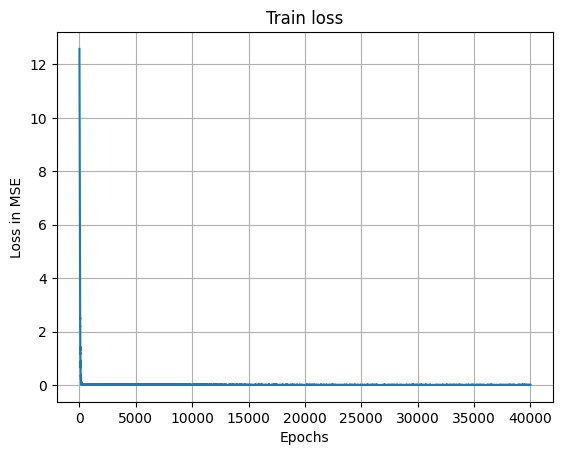

Final evaluation score is: 0.4541
['Final evaluation mse score is: 1.7374', 'Final evaluation mae score is: 1.0619', 'Final evaluation r2 score is: 0.4541']
Train evaluation score after: 0.6171 training.
['Train evaluation mse score is: 1.3499', 'Train evaluation mae score is: 0.9043', 'Train evaluation r2 score is: 0.6171']


In [562]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch_geometric.nn import to_hetero
import copy

def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.title("Train loss")
    plt.ylabel("Loss in MSE")
    plt.xlabel("Epochs")
    plt.grid()
    plt.show()

def refit(train_loader, hyperparameters, data = None):
    model, loss_list = train_k(train_loader, hyperparameters, data)
    return model, loss_list

def reevaluate(model, loader, data = None, mask = None):
    score, sec_scores = evaluate_k(model, loader, data, mask)
    return score, sec_scores#, (pred_target_values, true_target_values)
    
def final_train_and_evaluate(train_loader, test_loader, hyperparameters):
    model, loss_list = refit(train_loader, hyperparameters, data)
    plot_loss(loss_list)
    train_score_after_training, sec_train_scores = reevaluate(model, train_loader, data, data['model'].train_mask)
    score, sec_scores = reevaluate(model, test_loader, data, data['model'].test_mask)
    
    print(f"Final evaluation score is: {format(score, '.4f')}")
    print([f"Final evaluation {key} score is: {format(sec_scores[key], '.4f')}" for key in sec_scores])
    print(f"Train evaluation score after: {format(train_score_after_training, '.4f')} training.")
    print([f"Train evaluation {key} score is: {format(sec_train_scores[key], '.4f')}" for key in sec_train_scores])
    return loss_list #, (pred_target_values, true_target_values)

# training_score_before_training, sec_train_scores = reevaluate(best_hyperparams["model"], train_loader, data, data['model'].train_mask)
# print(f"Train evaluation score before: {format(training_score_before_training, '.4f')} training.")
# print([f"Train evaluation {key} score is: {format(sec_train_scores[key], '.4f')}" for key in sec_train_scores])

loss_list = final_train_and_evaluate(train_loader, test_loader, best_hyperparams)

In [555]:
## TOOD normalize based on number of neighbors

In [162]:
uniprot_to_go_df = pd.read_csv("uniprot_go_mappings.csv")
uniprot_to_go_df = uniprot_to_go_df.groupby("UniProt ID").aggregate(list).reset_index()
uniprot_to_go_df = uniprot_to_go_df.rename(columns={"UniProt ID": "uniprot_id", "GO Term": "go"})
exploded_protein_go_merge = pd.merge(proteomic_to_model_df, uniprot_to_go_df, how = "inner", on= "uniprot_id").explode("go")

In [163]:
uniprot_to_bioprocess_df = pd.read_csv("uniprot_to_bioprocess.csv")

In [164]:
bioprocess_to_bioprocess_parent_df = pd.read_csv("bioprocess_to_bioprocess_parent.csv")

In [165]:
bioprocess_to_bioprocess_parent_df = bioprocess_to_bioprocess_parent_df.copy()[bioprocess_to_bioprocess_parent_df["bioprocess_parent"] != 19959]

In [252]:
def recurse_bioprocesses(traversed_df, MAX_HOPS, depth = 0):
    # print(depth)
    # print(traversed_df["bioprocess_id"].unique().shape[0])
    # print((traversed_df["bioprocess_id"] == 19959).sum() / traversed_df["bioprocess_id"].shape[0])
    if depth == MAX_HOPS:
        return traversed_df
    merged_df = pd.merge(traversed_df, bioprocess_to_bioprocess_parent_df, on = "bioprocess_id", how = "inner")
    merged_df.pop("bioprocess_id")
    merged_df = merged_df.rename(columns= {"bioprocess_parent": "bioprocess_id"})
    depth += 1    
    return recurse_bioprocesses(merged_df, MAX_HOPS, depth)


In [280]:
def get_aggregated_proteomic_data(hops):
    traversed_df = uniprot_to_bioprocess_df.copy()
    uniprot_to_bioprocess = recurse_bioprocesses(traversed_df, hops)
    proteomic_bp_to_model_merge = pd.merge(proteomic_to_model_df, uniprot_to_bioprocess, how = "left", on= "uniprot_id")
    proteomic_bp_to_model_pivot = pd.pivot_table(proteomic_bp_to_model_merge, values='protein_intensity', index=['model_id'],
                       columns=['bioprocess_id'], aggfunc="sum", fill_value=0.0).reset_index()
    merged_reduced_protein_data = pd.merge(merged_drug_model_df.rename(columns = {"SANGER_MODEL_ID": "model_id"}), proteomic_bp_to_model_pivot, on = "model_id", how = "inner")
    y = merged_reduced_protein_data.pop("LN_IC50")
    merged_reduced_protein_data.pop("model_id")
    merged_reduced_protein_data.pop("model_idx")
    merged_reduced_protein_data.pop("MIN_CONC")
    return y.values, merged_reduced_protein_data.values

In [325]:
y, merged_reduced_protein_data = get_aggregated_proteomic_data(2)

In [336]:
traversed_df = uniprot_to_bioprocess_df.copy()
uniprot_to_bioprocess = recurse_bioprocesses(traversed_df, 2)
proteomic_bp_to_model_merge = pd.merge(proteomic_to_model_df, uniprot_to_bioprocess, how = "left", on= "uniprot_id")
proteomic_bp_to_model_pivot = pd.pivot_table(proteomic_bp_to_model_merge, values='protein_intensity', index=['model_id'],
                   columns=['bioprocess_id'], aggfunc="sum", fill_value=0.0).reset_index()
merged_reduced_protein_data = pd.merge(merged_drug_model_df.rename(columns = {"SANGER_MODEL_ID": "model_id"}), proteomic_bp_to_model_pivot, on = "model_id", how = "inner")
y = merged_reduced_protein_data.pop("LN_IC50")
merged_reduced_protein_data.pop("model_id")
merged_reduced_protein_data.pop("model_idx")
merged_reduced_protein_data.pop("MIN_CONC")

0      0.030016
1      0.030016
2      0.030016
3      0.030016
4      0.030016
         ...   
691    0.030016
692    0.030016
693    0.030016
694    0.030016
695    0.030016
Name: MIN_CONC, Length: 696, dtype: float64

In [337]:
train_index, test_index = train_test_split(np.arange(merged_reduced_protein_data.shape[0]), random_state = 42)

In [339]:
train_data = merged_reduced_protein_data.iloc[train_index, :]
test_data = merged_reduced_protein_data.iloc[test_index, :]
y_train = y.values[train_index]
y_test = y.values[test_index]

In [ ]:
from sklearn.preprocessing import normalize
y_train = normalize(np.expand_dims(y_train, axis = 0)).squeeze()
y_test = normalize(np.expand_dims(y_test, axis = 0)).squeeze()

In [340]:
y_test.shape

(174,)

In [341]:
from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler() #MinMaxScaler()
train_data_scaled =  min_max_scaler.fit_transform(train_data) #normalize(train_data)
test_data_scaled = min_max_scaler.transform(test_data) #normalize(test_data)

In [342]:
train_data_scaled.shape

(522, 3887)

In [343]:
from scipy.stats import pearsonr

min_var_features = []
for i in range(train_data_scaled.shape[-1]):
    rows = train_data_scaled[:, i]
    corr_value = pearsonr(rows, y_train).statistic
    if np.abs(corr_value) >= 1e-10:
        min_var_features.append(i)
len(min_var_features)

3887

In [344]:
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor

model = XGBRegressor
lr = model(alpha = 100 )
lr.fit(train_data_scaled, y_train)

XGBRegressor(alpha=100, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [345]:
test_data_scaled.shape, train_data_scaled.shape

((174, 3887), (522, 3887))

In [346]:
y_test.shape

(174,)

In [347]:
from sklearn.metrics import r2_score

r2_score(y_test, lr.predict(test_data_scaled)), r2_score(y_train, lr.predict(train_data_scaled))

(-5.908118284558839e-05, 0.17803981637019706)

In [348]:
from  sklearn.model_selection import GridSearchCV

low = 0
high = 100
param_grid = {
    "alpha":np.linspace(low, high, high - low +1 , endpoint=True)
}
grid_search = GridSearchCV(
    model(),
    n_jobs=-1,
    param_grid = param_grid,
    cv = 3,
    scoring = "r2"
)
grid_search.fit(train_data_scaled[:, min_var_features], y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])},
             scoring='r2')

In [349]:
grid_search.best_params_, grid_search.best_score_

({'alpha': 43.0}, 0.05970144058082919)

In [350]:
r2_score(y_test, grid_search.predict(test_data_scaled[:, min_var_features])), r2_score(y_train, grid_search.predict(train_data_scaled[:, min_var_features]))

(-0.0536518819158609, 0.6456758936623965)

In [151]:
## Do we have some previous knowledge where we can exclude the relevance of specific biological processes?

In [242]:
def get_scaled_data(X, train_index, test_index, scaler = None):
    X_train = X[train_index]
    X_test = X[test_index]
    if scaler is None: return X_train, X_test
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [278]:
model = XGBRegressor

In [279]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
splits = 3
kf = KFold(n_splits=splits,shuffle=True)
scalers = [preprocessing.MinMaxScaler(), preprocessing.StandardScaler(), None]
res = np.zeros(splits)

for i, (train_index, test_index) in tqdm(enumerate(kf.split(np.arange(696)))):
    best_score = float("-inf")
    best_params = None
    best_configs = dict({"hop": None, "scaler": None})
    
    for hop in tqdm(range(1, 4)):
        y, X = get_aggregated_proteomic_data(hop)
        y_train, y_test = y[train_index], y[test_index]
        
        for scaler in scalers:
            X_train, X_test = get_scaled_data(X, train_index, test_index, scaler)
            
            ## Scale also y???
            
            low = 0
            high = 100
            param_grid = {"alpha":np.linspace(low, high, high - low +1 , endpoint=True)}
            grid_search = GridSearchCV(
                model(),
                n_jobs=-1,
                param_grid = param_grid,
                cv = 3,
                scoring = "r2")
            grid_search.fit(X_train, y_train)
            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_params = grid_search.best_params_
                best_configs["hop"] = hop
                best_configs["scaler"] = scaler
                print(f"{best_score}: {best_configs}")
    y, X = get_aggregated_proteomic_data(best_configs["hop"])
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = get_scaled_data(X, train_index, test_index, best_configs["scaler"])
    model.fit(**best_params)
    r2_results = r2_score(y_test, model.predict(X_test))
    res[i] = r2_results
print(f"{res.mean()} +- {res.std()}")

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

-9.072930378453874: {'hop': 1, 'scaler': MinMaxScaler()}


Process LokyProcess-338:
Process LokyProcess-344:
Process LokyProcess-352:
Process LokyProcess-335:
Process LokyProcess-353:
Process LokyProcess-358:
Process LokyProcess-334:
Process LokyProcess-355:
Process LokyProcess-359:
Process LokyProcess-339:
Process LokyProcess-341:
Process LokyProcess-346:
Process LokyProcess-330:
Process LokyProcess-327:
Process LokyProcess-326:
Process LokyProcess-332:
Process LokyProcess-331:
Process LokyProcess-354:
Process LokyProcess-363:
Process LokyProcess-325:
Process LokyProcess-321:
Process LokyProcess-348:
Process LokyProcess-360:
Process LokyProcess-357:
Process LokyProcess-345:
Process LokyProcess-329:
Process LokyProcess-362:
Process LokyProcess-361:
Process LokyProcess-347:
Process LokyProcess-324:
Process LokyProcess-364:
Process LokyProcess-350:
Process LokyProcess-351:
Process LokyProcess-356:
Process LokyProcess-340:
Process LokyProcess-322:
Process LokyProcess-343:
Process LokyProcess-323:
Process LokyProcess-342:
Process LokyProcess-349:


KeyboardInterrupt: 

In [267]:
proteome_table = pd.pivot_table(proteomic_to_model_df, values='protein_intensity', index=['model_id'],
                       columns=['uniprot_id'], aggfunc="sum", fill_value=0.0)
proteome_table_merged = pd.merge(merged_drug_model_df.rename(columns = {"SANGER_MODEL_ID": "model_id"}), proteome_table, on = "model_id", how = "inner")

In [268]:
proteome_table_merged

,model_id,MIN_CONC,LN_IC50,model_idx,A0A075B6K4,A0A075B6N1,A0A075B7B8,A0A075B7D8,A0A087X0M5,A0A0B4J1V0,...,Q9Y6V0,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,SIDM01132,0.030016,5.078148,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.38499,2.478020,4.79677,3.66727,0.00000,0.000000,0.00000,3.01557,0.000000,3.66191
1,SIDM00848,0.030016,2.849687,1,0.0,0.0,0.0,0.0,0.0,0.0,...,3.21332,2.067740,4.51982,4.56456,0.00000,0.000000,2.26890,3.67573,2.864420,3.72880
2,SIDM00263,0.030016,5.814401,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,1.865560,4.07119,4.05313,3.01002,0.527221,3.18820,2.59367,-0.372063,2.70822
3,SIDM00269,0.030016,3.390164,3,0.0,0.0,0.0,0.0,0.0,0.0,...,3.24159,-0.075127,4.24225,3.82222,3.15247,0.000000,0.00000,1.04894,3.046890,4.16562
4,SIDM00203,0.030016,6.030742,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,-1.130470,4.16679,3.75188,0.00000,2.082380,2.79088,3.58533,2.074080,2.63864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,SIDM00214,0.030016,4.973348,712,0.0,0.0,0.0,0.0,0.0,0.0,...,4.63727,0.000000,0.00000,4.53678,0.00000,2.337140,1.50818,2.81642,3.200490,3.73990
692,SIDM00194,0.030016,3.812519,713,0.0,0.0,0.0,0.0,0.0,0.0,...,5.68525,-0.059671,4.56068,3.07724,0.00000,2.236390,0.00000,1.30044,0.000000,2.94487
693,SIDM00193,0.030016,2.698528,714,0.0,0.0,0.0,0.0,0.0,0.0,...,4.40518,1.226040,4.79602,4.80620,2.41336,0.101013,2.80196,3.06613,0.000000,2.91771
694,SIDM00498,0.030016,7.079313,715,0.0,0.0,0.0,0.0,0.0,0.0,...,4.18342,1.997690,3.37983,3.75180,2.36091,3.161740,0.00000,3.53633,0.000000,2.46901


In [65]:
import torch
import gc

# Assume tensor is a CUDA tensor you no longer need
del train_loader
del test_loader

# Empty the CUDA cache
torch.cuda.empty_cache()

# Run garbage collection
gc.collect()


3446

## Log of experiments
1) Selected genes with custom HetGNN -> Works (Data reading, processing and training works)
2) Selected genes with custom HetGNN with batches -> Doesnt work (batching in graphs is problematic???)
3) Selected genes with HeteroGATConv2 -> Overfits even with one head
4) Selected genes + all proteins with custom HetGNN without batches -> Requires too much RAM
5) Selected genes + all proteins with custom HetGNN with batches -> Exploding/Vanishing gradients due to missing normalization in aggregation (normalize based on edge degree?)
6) Selected genes + all proteins with custom HeteroGatConv2 with batches -> Does not work (tried many configs and doesnt even overfit), either architecture or batches are problem
7) Selected genes + selected proteins (low degree and high degree/high var edges) with custom HeteroGatConv2 with batches -> Does not work, either architecture or batches are problem
8) Selected genes + selected proteins with HetGNN and single batch -> Works wih r2 about 0.1/0.2 but worse than only selected genes (due to overfit might companesate with dropout, wd, andearly stopping)
9) Selected proteins with HetGNN and single batch -> (if this would work we can try ensembles of GNNs trained in different features) overfits even with high dropouts like 0.7
10) Pearson based protein selection with 0.2 as threshold and 300 sparsity threshold, 1e-4 lr and 10000 epochs without genes -> r2 of  0.16 (try spearman corr or other thresholds ? ), 0.1 with 500, 1e-4 and 30_000 epochs returned 0.23
11) Similar procedures for genes and already have 0.45 for 40_000 epochs and dropout 0.1

Comparison against Feature selection of Johannes Schwerdt and Emanuel Lange? 

In [ ]:
data

In [ ]:
data["protein"].x.shape[0]

In [ ]:
def get_new_features(edge_index_dict, edge_attr_dict, x_dict):
    message_dict = dict()
    for key in edge_index_dict:
        source, edge, target = key
        edge_index = edge_index_dict[key]
               
        messages = edge_attr_dict[key] 
        aggregated_messages = torch.zeros((x_dict[target].shape[0], messages.shape[1]), dtype=x_dict[target].dtype)
        
        broadcasted_target_index = explicit_broadcast(edge_index[1], messages)
        aggregated_messages.scatter_reduce_(0, broadcasted_target_index, messages, "sum")
        message_dict[key] = aggregated_messages
        
    ## Message aggregation
    message_aggr_dict = dict()
    for key in message_dict:
        source, edge, target = key
        messages_for_target = message_dict[key]
        previous_message_aggr_target = message_aggr_dict.get(target, None)
        if previous_message_aggr_target is None:
            message_aggr_dict[target] = messages_for_target
        else:
            message_aggr_dict[target] = torch.cat((previous_message_aggr_target, messages_for_target), dim = 1)
    return message_aggr_dict["model"]

In [ ]:
new_data = get_new_features(data.edge_index_dict, data.edge_attr_dict, data.x_dict)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
##TODO change to train,. test val indices form above
X_train, X_test , y_train, y_test = train_test_split(new_data, target_labels, random_state=0)
# standard_scaler = StandardScaler()
# standard_scaler.fit(X_train)

# X_train, X_test = standard_scaler.transform(X_train), standard_scaler.transform(X_test)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer, r2_score

# Define the XGBoost regressor
xgb_reg = XGBRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 5, 10, 20],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1.0],
}
r2_scorer = make_scorer(r2_score)
# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring=r2_scorer, verbose=1, n_jobs = -1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


In [215]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

base_model = XGBRegressor(**grid_search.best_params_)
base_model.fit(X_train, y_train)

{
    "train_rmse":root_mean_squared_error(y_train, base_model.predict(X_train)),
    "train_r2":r2_score(y_train, base_model.predict(X_train)),
    "test_rmse": root_mean_squared_error(y_test, base_model.predict(X_test)),
    "test_r2":r2_score(y_test, base_model.predict(X_test))
}

{'train_rmse': 1.4344861423667379,
 'train_r2': 0.41209220806541835,
 'test_rmse': 1.8167445670845757,
 'test_r2': -0.014697180086989503}

## Test for Cross validaion index translator

In [50]:
k_fold = KFold(n_splits=5)
for (idx, val_idx) in k_fold.split(train_indices):
    print(30*"#")
    # print(train_indices[idx])
    # print(train_indices[val_idx])

    ## Test
    sorted_k_folds = torch.sort(torch.cat([train_indices[idx], train_indices[val_idx]], 0))[0]
    sorted_all_indices = torch.sort(train_indices)[0]
    mathing_indices = (sorted_all_indices == sorted_k_folds).sum()
    print(mathing_indices == train_indices.shape[0])

##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)
##############################
tensor(True)


## Empty GPU memory

In [166]:
del model, loss_fn, optim
torch._C._cuda_clearCublasWorkspaces()
torch._dynamo.reset()
import gc
gc.collect()
torch.cuda.empty_cache()

## Base model

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
##TODO change to train,. test val indices form above
X_train, X_test , y_train, y_test = train_test_split(model_and_target_features, target_labels, random_state=0)
standard_scaler = StandardScaler()
standard_scaler.fit(X_train)

X_train, X_test = standard_scaler.transform(X_train), standard_scaler.transform(X_test)

In [280]:
model

array([[5.5100e+02, 3.0016e-02, 3.3800e+02, ..., 4.0000e+00, 1.2000e+01,
        0.0000e+00],
       [2.4000e+01, 3.0016e-02, 7.1000e+01, ..., 4.0000e+00, 1.2000e+01,
        1.0000e+00],
       [1.5500e+02, 3.0016e-02, 7.1300e+02, ..., 4.0000e+00, 1.2000e+01,
        1.0000e+00],
       ...,
       [6.3300e+02, 3.0016e-02, 6.1000e+02, ..., 4.0000e+00, 1.3000e+01,
        1.0000e+00],
       [6.3600e+02, 3.0016e-02, 9.4100e+02, ..., 4.0000e+00, 1.3000e+01,
        1.0000e+00],
       [1.3600e+02, 3.0016e-02, 7.3300e+02, ..., 4.0000e+00, 1.2000e+01,
        1.0000e+00]])

In [277]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

base_model = MLPRegressor(hidden_layer_sizes=(20))
base_model.fit(X_train, y_train)

/home/dwalke/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=20)

In [278]:
from sklearn.metrics import root_mean_squared_error, r2_score
{
    "train_rmse":root_mean_squared_error(y_train, base_model.predict(X_train)),
    "train_r2":r2_score(y_train, base_model.predict(X_train)),
    "test_rmse": root_mean_squared_error(y_test, base_model.predict(X_test)),
    "test_r2":r2_score(y_test, base_model.predict(X_test))
}

{'train_rmse': 0.630041661641547,
 'train_r2': 0.2358449424336172,
 'test_rmse': 0.7127170857289105,
 'test_r2': 0.036665393902286736}

## Old code

In [ ]:
raise Exception("Keep cell outputs here")

In [133]:
# pivot_targets = pd.pivot_table(targets, values="LN_IC50", index=["SANGER_MODEL_ID"],
#                        columns=['DRUG_ID'])

# pd.merge(targets.loc[:, ["SANGER_MODEL_ID",'PUTATIVE_TARGET', 'PATHWAY_NAME', 'MIN_CONC', 'MAX_CONC']], pivot_targets, on=["SANGER_MODEL_ID","SANGER_MODEL_ID"])

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,...,NaN,2.366388,NaN,NaN,NaN,NaN,NaN,NaN,7.846626,10.613759
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.723942,5.240599,4.432934,4.716167,4.285911,7.793623,9.156372,7.568813,7.063871
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,...,4.879849,1.901766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,2.133421,4.578782,3.893851,3.137208,2.719145,8.871504,9.302207,6.655762,9.441838
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.880307,5.137711,4.863771,5.007426,5.389040,10.462131,9.801610,8.228663,10.817398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242031,GDSC2,401,19187490,1659928,SNU-175,SIDM00216,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,1.310061,5.423870,5.397164,5.401524,4.973343,9.264933,9.211173,7.445385,10.134495
242032,GDSC2,401,19187943,1660034,SNU-407,SIDM00214,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.628609,5.042005,5.055076,4.918666,4.122141,11.121460,9.528520,8.344004,8.575555
242033,GDSC2,401,19188201,1660035,SNU-61,SIDM00194,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.866949,6.130028,5.649833,4.392357,4.382946,10.879932,10.092187,7.743591,10.520666
242034,GDSC2,401,19188741,1674021,SNU-C5,SIDM00498,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.653533,6.151265,6.022426,5.661197,4.820414,9.652950,10.181355,7.305220,10.701430


In [79]:
# ~pivot_targets.isnull()

DRUG_ID,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00003,True,True,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
SIDM00023,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00040,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00041,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00042,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01248,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01251,True,True,True,True,True,False,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01259,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
